## 1. Importing Libraries and generating Datasets

In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

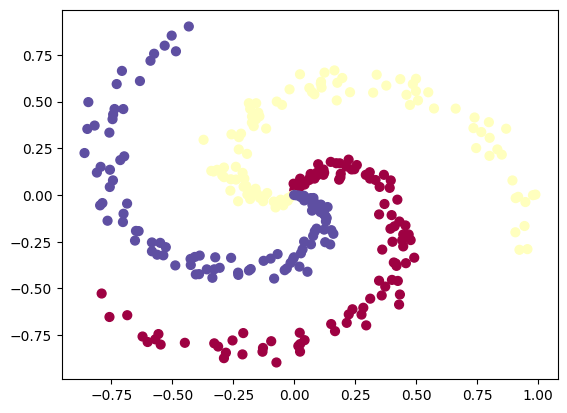

In [3]:
# Code for creating a spiral dataset from CS231n
import numpy as np
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

In [4]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.LongTensor)

## 2. Creating Class and Spliting to train and Test

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"

class SpiralModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear1 = nn.Linear(in_features=2, out_features=10)
    self.linear2 = nn.Linear(in_features=10, out_features=10)
    self.linear3 = nn.Linear(in_features=10, out_features=3)
    self.relu = nn.ReLU()

  def forward(self, x):
    return self.linear3(self.relu(self.linear2(self.relu(self.linear1(x)))))

model = SpiralModel().to(device)
model

SpiralModel(
  (linear1): Linear(in_features=2, out_features=10, bias=True)
  (linear2): Linear(in_features=10, out_features=10, bias=True)
  (linear3): Linear(in_features=10, out_features=3, bias=True)
  (relu): ReLU()
)

In [7]:
# importing Loss and Optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

In [11]:
y_logist = model(X_test)
y_pred = torch.softmax(y_logist, dim=1).argmax(dim=1)

In [12]:
torch.manual_seed(42)
epochs = 1001

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  model.train()

  y_logist = model(X_train).squeeze()

  y_prep = torch.round(torch.softmax(y_logist, dim=1)).argmax(1)

  loss = loss_fn(y_logist, y_train)

  acc = accuracy_fn(y_true=y_train, y_pred=y_prep)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model.eval()

  with torch.inference_mode():
    test_logist = model(X_test).squeeze()
    test_loss = loss_fn(test_logist, y_test)

    test_y_prep = torch.round(torch.softmax(test_logist, dim=1)).argmax(1)
    test_acc = accuracy_fn(y_true=y_test, y_pred=test_y_prep)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss} , Accuracy: {acc} | Test Loss: {test_loss}, Test Accuracy: {test_acc}")

Epoch: 0 | Loss: 1.0972245931625366 , Accuracy: 32.5 | Test Loss: 1.1148678064346313, Test Accuracy: 36.666666666666664
Epoch: 100 | Loss: 0.34082695841789246 , Accuracy: 84.58333333333333 | Test Loss: 0.3412899374961853, Test Accuracy: 83.33333333333334
Epoch: 200 | Loss: 0.08235108107328415 , Accuracy: 97.5 | Test Loss: 0.05465903505682945, Test Accuracy: 100.0
Epoch: 300 | Loss: 0.04511422663927078 , Accuracy: 98.33333333333333 | Test Loss: 0.02042725868523121, Test Accuracy: 100.0
Epoch: 400 | Loss: 0.03273819759488106 , Accuracy: 99.16666666666667 | Test Loss: 0.009514004923403263, Test Accuracy: 100.0
Epoch: 500 | Loss: 0.02646993286907673 , Accuracy: 99.16666666666667 | Test Loss: 0.00415921350941062, Test Accuracy: 100.0
Epoch: 600 | Loss: 0.022570036351680756 , Accuracy: 99.16666666666667 | Test Loss: 0.0018350161844864488, Test Accuracy: 100.0
Epoch: 700 | Loss: 0.020312625914812088 , Accuracy: 99.16666666666667 | Test Loss: 0.0009280876838602126, Test Accuracy: 100.0
Epoch: 

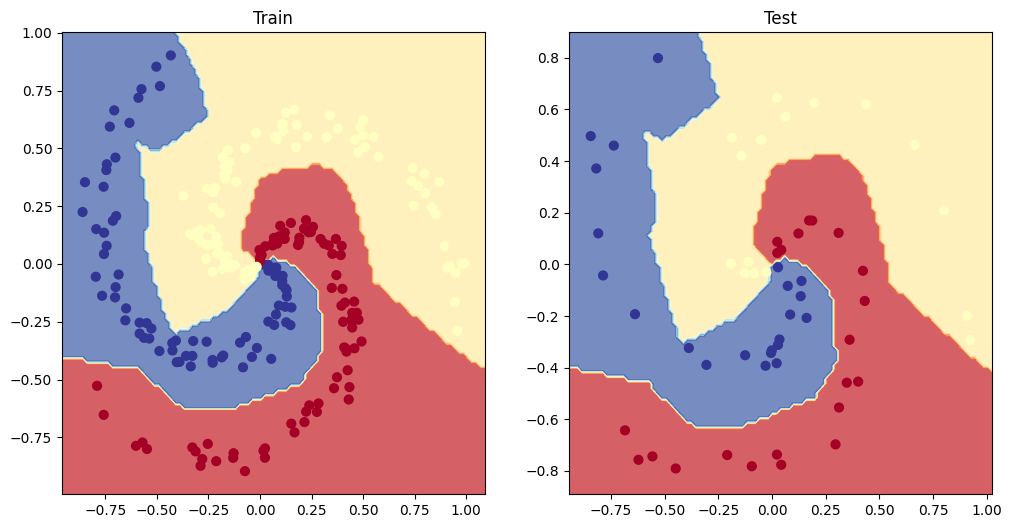

In [13]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test)